Copyright (c) 2019, Vienna University of Technology (TU Wien), Department of Geodesy and Geoinformation (GEO).
All rights reserved.

All information contained herein is, and remains the property of Vienna University of Technology (TU Wien), Department of Geodesy and Geoinformation (GEO). The intellectual and technical concepts contained herein are proprietary to Vienna University of Technology (TU Wien), Department of Geodesy and Geoinformation (GEO). Dissemination of this information or reproduction of this material is forbidden unless prior written permission is obtained from Vienna University of Technology (TU Wien), Department of Geodesy and Geoinformation (GEO).

## Introduction

To view this notebook online, paste the github URL to: https://nbviewer.jupyter.org/

The C3S Soil Moisture data used in this example can be downloaded from the Copernicus Climate Data Store (CDS): https://cds.climate.copernicus.eu/

The data can be downloaded as daily, dekadal (10-daily) or monthly global images. These images can be converted to timeseries data using the c3s_sm package (which can be downloaded from the pypi server using "pip install c3s-sm"). Information on how to use this package, including reading of the timeseries, is available on readthedocs: https://c3s-sm.readthedocs.io/en/latest/

This example takes a small subset of timeseries data and shows how this could be used to calculate a monthly climatology and assocaited anomalies for 5 different locations each with different land cover types.

## Setting up the Python Environment

In [1]:
#Importing required packages
import os
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows',15) #limit the number of rows seen when priting data
%pylab inline 
plt.rcParams['figure.figsize'] = [15, 5]

Populating the interactive namespace from numpy and matplotlib


## Locations of data used in this study

Five locations representing different land cover types are used in this example. The timeseries data has been extracted from the netCDF files and saved to a text file provided in the repository (C3S_v201812_COMBINED_sample.csv). The locations are as follows:

| Climate Class 	| Land Cover Type   	| Country   	| C3S grid point locator 	| Latitude 	| Longitude 	|
|---------------	|-------------------	|-----------	|------------------------	|----------	|-----------	|
| Dsc           	| Sparse vegetation 	| USA       	| 890047                 	| 64.625   	| -148.125  	|
| Cfa           	| Cropland          	| Australia 	| 316669                 	| -35.125  	| 147.375   	|
| BSk           	| Cropland          	| Spain     	| 756697                 	| 41.375   	| -5.625    	|
| Cfb           	| Grassland         	| Germany   	| 810025                 	| 50.625   	| 6.375     	|
| Cfa           	| Broadleaf forest    	| USA       	| 733335                 	| 37.375   	| -86.125       |

<img src="Timeseries_locations.png" width="650">

We set the locations and corresponding land cover types as variables for use by the python script:

In [2]:
#Setting the locations and making sure the path exists
locations =['890047', '316669', '756697', '810025', '733335']
locations_lctype = ['sparse vegetation', 'cropland', 'cropland', 'grassland', 'broadleaf forest']


## Importing the data 

The data is read from the csv file (available in the github repository). First we define the name of the file and check that it exists:

In [3]:
data_path = 'C3S_v201812_COMBINED_sample.csv'
print('The data exists: {}'.format(os.path.exists(data_path))) #Check that the data exists

The data exists: True


Then we read the data in using pandas. As we are working with timeseries data, we set the index to the 

In [4]:
data = pd.read_csv(data_path)
data = data.set_index(pd.DatetimeIndex(data['Unnamed: 0'])) #read in the data with the date column as the index
data = data.drop('Unnamed: 0', axis=1) #drop the original date column
print(data)

              890047    316669    756697    810025    733335
Unnamed: 0                                                  
1978-11-30       NaN  0.218465  0.208171  0.317902  0.323576
1978-12-31       NaN  0.163733  0.304086       NaN  0.346390
1979-01-31       NaN  0.130110       NaN       NaN  0.327454
1979-02-28       NaN  0.124208       NaN       NaN  0.373103
1979-03-31       NaN  0.112285       NaN       NaN  0.350780
1979-04-30  0.181290  0.155497  0.289984  0.301838  0.338183
1979-05-31  0.216451  0.183292  0.144036  0.381720  0.283763
...              ...       ...       ...       ...       ...
2018-06-30  0.251167  0.237288  0.253351  0.284938  0.292009
2018-07-31  0.224239  0.222222  0.188741  0.258218  0.277325
2018-08-31  0.220967  0.201081  0.144443  0.262571  0.282387
2018-09-30  0.226162  0.158831  0.171527  0.278190  0.298709
2018-10-31  0.214188  0.148635  0.193467  0.289969  0.302967
2018-11-30       NaN  0.186218  0.277402  0.314909  0.335898
2018-12-31       NaN  0.

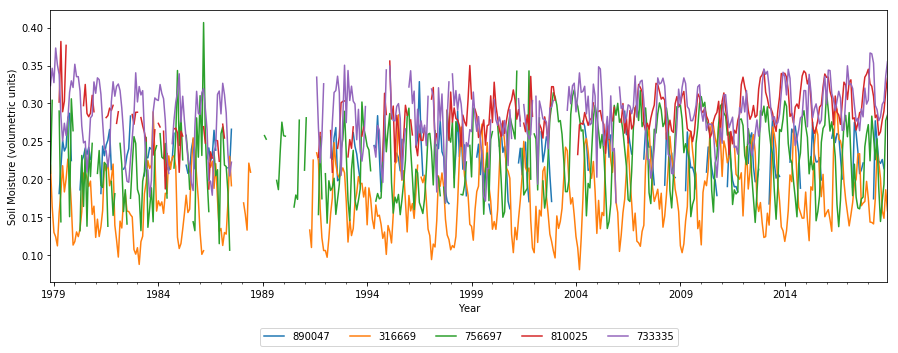

In [38]:
ax = data.plot()
ax.set_xlabel("Year") #add the x axis label
ax.set_ylabel("Soil Moisture (volumetric units)") #set the y axis label
box = ax.get_position() #get the location of the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5) #place the legend

## Generating Monthly Climatology

To generate the anomalies, we need to know what the normal conditions are at these locations, i.e. the climatology. To do this, we subset the data for the years 1991 to 2010 and generate a mean value for each month of all years, i.e. we average all January values between 1991 and 2010, all February values between 1991 and 2010 etc.

In [6]:
clim_subset = data.copy() #copy the data to a new dataframe
clim_subset = clim_subset['1991':'2010'] #subset the data between 1991 and 2010
clim = data.groupby(data.index.month).mean() #calculate the monthly means of the data

In this step, we also add a 'month' field which will be used in generating the anomalies later.

In [7]:
clim['month'] = clim.index #add a month column which will be used later on for the anomaly calculation
print(clim)

              890047    316669    756697    810025    733335  month
Unnamed: 0                                                         
1                NaN  0.134338  0.269024  0.302228  0.304895      1
2                NaN  0.138394  0.260104  0.302469  0.322250      2
3           0.202302  0.141565  0.242336  0.289481  0.316061      3
4           0.204993  0.152049  0.238691  0.281241  0.300733      4
5           0.247022  0.180089  0.230397  0.266316  0.273229      5
6           0.240339  0.224514  0.208571  0.263884  0.264798      6
7           0.241540  0.234881  0.173340  0.272930  0.261347      7
8           0.227423  0.220368  0.162715  0.271203  0.259560      8
9           0.226212  0.199311  0.191073  0.270247  0.252778      9
10          0.205839  0.192231  0.227061  0.280148  0.257237     10
11          0.178956  0.178708  0.256962  0.303963  0.288120     11
12          0.161225  0.151306  0.270827  0.302536  0.309139     12


We can now plot the climatologies for the locations:

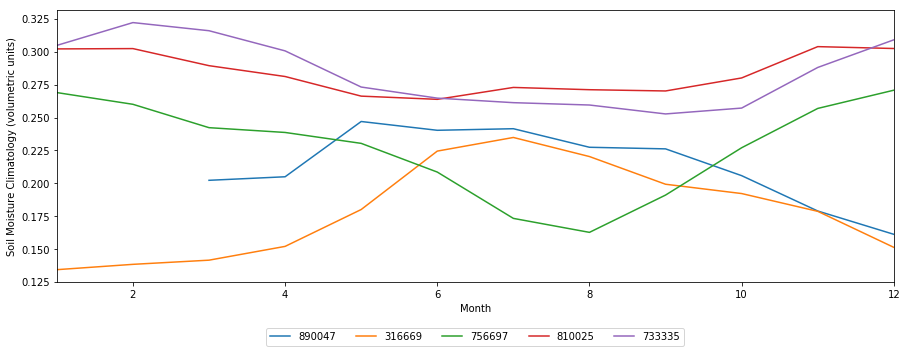

In [39]:
ax = clim[locations].plot() #plot the climatology
ax.set_xlabel("Month") #add the x axis label
ax.set_ylabel("Soil Moisture Climatology (volumetric units)") #set the y axis label
box = ax.get_position() #get the location of the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5) #place the legend

## Generating Monthly Anomalies for 2018

Anomalies are the deviation in soil moisture from the normal conditions, i.e. the climatologies calculated above. The anomalies are calculated here for our five locations for the year 2018. To do this, we first subset the data to get only values for 2018:

In [9]:
subset = data['2018'].copy() #subset for 2018 only values (make a copy of original data)
subset['month'] = subset.index.month #add a month column which will be used later on for the anomaly calculation
print(subset)

              890047    316669    756697    810025    733335  month
Unnamed: 0                                                         
2018-01-31       NaN  0.174957  0.272095  0.345145  0.304554      1
2018-02-28       NaN  0.143646  0.224433  0.325941  0.366566      2
2018-03-31       NaN  0.143200  0.283313  0.322684  0.365459      3
2018-04-30  0.174353  0.141238  0.256884  0.309404  0.353204      4
2018-05-31  0.277150  0.174023  0.225893  0.281323  0.297470      5
2018-06-30  0.251167  0.237288  0.253351  0.284938  0.292009      6
2018-07-31  0.224239  0.222222  0.188741  0.258218  0.277325      7
2018-08-31  0.220967  0.201081  0.144443  0.262571  0.282387      8
2018-09-30  0.226162  0.158831  0.171527  0.278190  0.298709      9
2018-10-31  0.214188  0.148635  0.193467  0.289969  0.302967     10
2018-11-30       NaN  0.186218  0.277402  0.314909  0.335898     11
2018-12-31       NaN  0.158572  0.284637  0.333376  0.355072     12


We can now join the data from the climatology and anomaly fields together using the 'month' field added to each dataframe in previous steps. This results in a dataframe containing soil moisture values and the soil moisture climatology for each location for all months of 2018.

In [16]:
ano_clim = subset.merge(clim, how='left', left_on='month', right_on='month', suffixes=('', '_clim'))
ano_clim = ano_clim.set_index(pd.DatetimeIndex(subset.index.values))
print('Columns in the dataframe: {}'.format(ano_clim.columns.values))

Columns in the dataframe: ['890047' '316669' '756697' '810025' '733335' 'month' '890047_clim'
 '316669_clim' '756697_clim' '810025_clim' '733335_clim']


We can use this dataframe ('ano_clim') to go through all the locations and generate the anomalies for each. This is avhieved by subtracting the climatology value from the soil moisture value and results in the 2018 anomalies for each month of 2018.

In [17]:
for g in locations:
    ano_clim['{}_ano'.format(g)] = ano_clim[[g]].sub(ano_clim['{}_clim'.format(g)], axis=0)
ano = ano_clim.filter(regex='_ano').copy()
print(ano)

            890047_ano  316669_ano  756697_ano  810025_ano  733335_ano
2018-01-31         NaN    0.040619    0.003071    0.042916   -0.000341
2018-02-28         NaN    0.005252   -0.035671    0.023472    0.044316
2018-03-31         NaN    0.001635    0.040977    0.033203    0.049397
2018-04-30   -0.030639   -0.010811    0.018193    0.028163    0.052472
2018-05-31    0.030128   -0.006066   -0.004504    0.015007    0.024241
2018-06-30    0.010827    0.012774    0.044780    0.021054    0.027211
2018-07-31   -0.017301   -0.012659    0.015400   -0.014712    0.015978
2018-08-31   -0.006456   -0.019287   -0.018272   -0.008632    0.022827
2018-09-30   -0.000050   -0.040480   -0.019546    0.007942    0.045931
2018-10-31    0.008349   -0.043596   -0.033594    0.009821    0.045730
2018-11-30         NaN    0.007510    0.020440    0.010945    0.047778
2018-12-31         NaN    0.007267    0.013810    0.030840    0.045933


Now we can plot the final anomalies for each location:

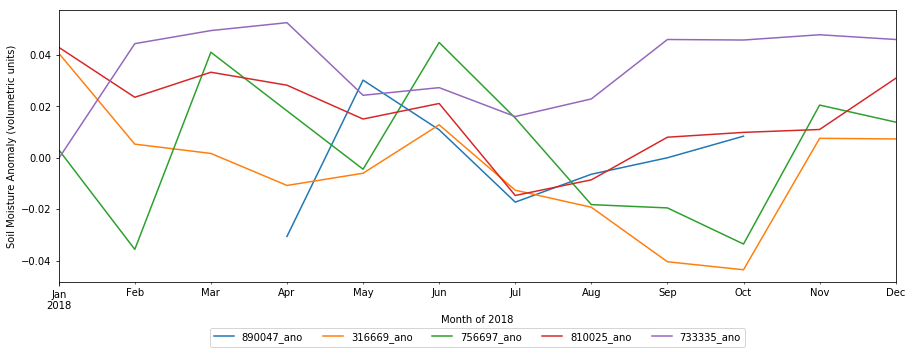

In [40]:
ax = ano.plot()
ax.set_xlabel("Month of 2018") #add the x axis label
ax.set_ylabel("Soil Moisture Anomaly (volumetric units)") #set the y axis label
box = ax.get_position() #get the location of the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5) #place the legend